In [1]:
import pandas as pd
import numpy as np
from datetime import date
import holidays
from fbprophet import Prophet

Считываем csv-файл в датафрейм

In [2]:
df = pd.read_csv(r'C:\Репорты\test_data_to_preditct\organic_extract.csv')
df = df.rename(columns = {
    "Sessions": "y",
    "Date": "ds"
})
df.head()

,Unnamed: 0,ds,y
0,0,1/1/2018,204
1,1,1/2/2018,217
2,2,1/3/2018,221
3,3,1/4/2018,225
4,4,1/5/2018,215


Важно, что бы колонки назывались именно так, как в примере.
Даты - ds
Метрика, которую мы будем прогнозировать - y

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1043 non-null   int64 
 1   ds          1043 non-null   object
 2   y           1043 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 24.6+ KB


Вроде все хорошо, данные за два года, но нужно минимально их предобработать - в частности, распарсить данные из колонки с датой в объект типа Date

In [4]:
df['ds'] = pd.to_datetime(df.ds)

Нам также понадобиться календарь праздников в стране, для учета сезонности. Я использовал календарь США, если вы живете в какой-то экзотической стране, которая не учтена в библиотеки holidays - создайте свой датафрейм с праздниками в вашей стране.

In [5]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.US(years=(2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head()

,ds,holiday
0,2018-01-01,New Year's Day
1,2018-01-15,Martin Luther King Jr. Day
2,2018-02-19,Washington's Birthday
3,2018-05-28,Memorial Day
4,2018-07-04,Independence Day


Этот кусок будет овечать за проверку модели. Т.е. мы отрежем от фактических данных последние 30 дней, сделаем на них предикт и потом сравним с фактическим данными для оценки качества полученной модели

In [6]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df[:-predictions]

In [7]:
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [8]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

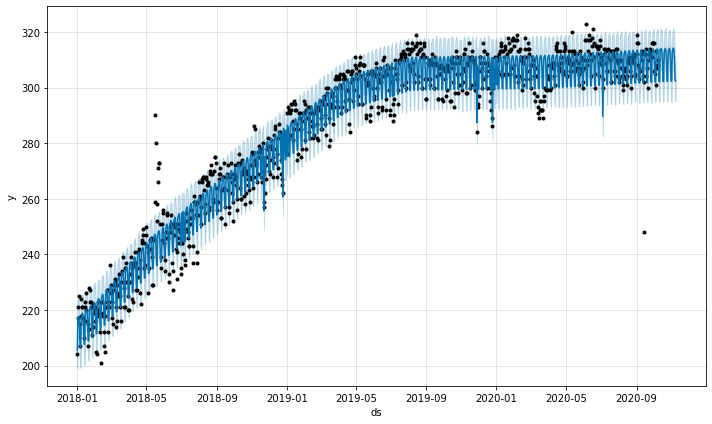

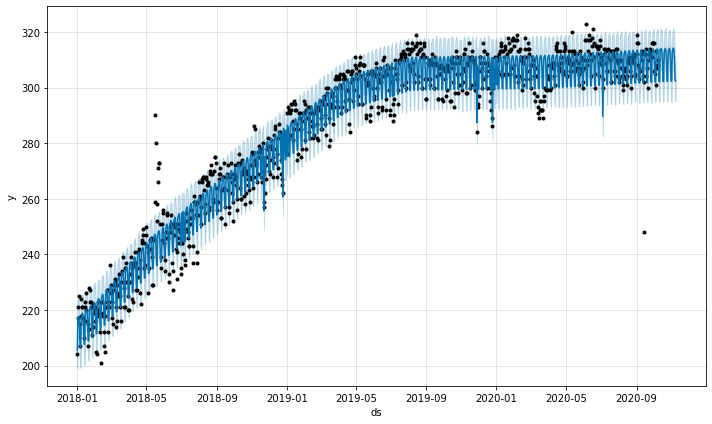

In [9]:
# Смотрим, что предсказалось
m.plot(forecast)

Посмотрим на сезонности

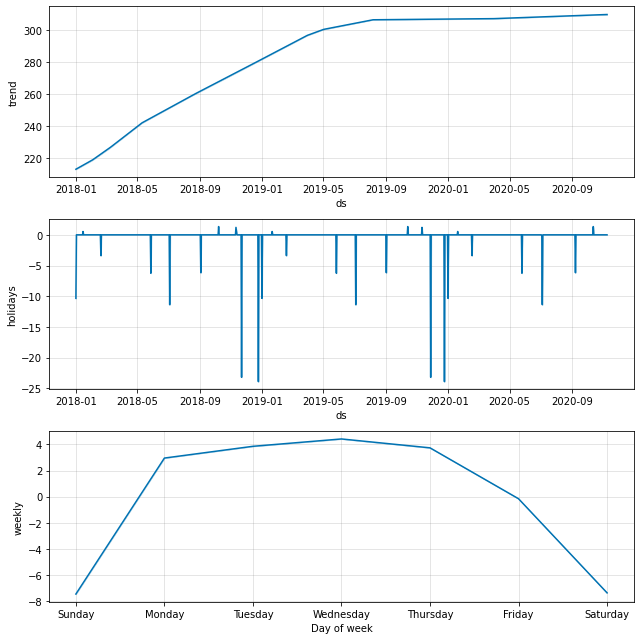

In [10]:
m.plot_components(forecast);

Рисуем график с границами прогноза

In [11]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

Итак, момент истины, посмотрим, насколько часто и сильно ошибается модель

In [12]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  0.8703339636447558 %
MAE (средняя абсолютная ошибка) –  2.6872458338804828


Ну и собственно сам прогноз, необходимое кол-во дней для прогноза можно указать в prediction_days

In [13]:
prediction_days = 90
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

In [14]:
final_forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,212.865275,198.386957,212.016113,212.865275,212.865275,0.0,0.0,0.0,0.0,...,-10.258327,-10.258327,-10.258327,2.948189,2.948189,2.948189,0.0,0.0,0.0,205.555137
1,2018-01-02,213.042489,209.995721,223.776689,213.042489,213.042489,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,3.804948,3.804948,3.804948,0.0,0.0,0.0,216.847437
2,2018-01-03,213.219703,210.777193,225.004816,213.219703,213.219703,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,4.352036,4.352036,4.352036,0.0,0.0,0.0,217.571739
3,2018-01-04,213.396918,210.128615,223.928681,213.396918,213.396918,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,3.676245,3.676245,3.676245,0.0,0.0,0.0,217.073163
4,2018-01-05,213.574132,206.122736,220.201972,213.574132,213.574132,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.158257,-0.158257,-0.158257,0.0,0.0,0.0,213.415875
5,2018-01-06,213.751347,199.464732,213.315472,213.751347,213.751347,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-7.283405,-7.283405,-7.283405,0.0,0.0,0.0,206.467941
6,2018-01-07,213.928561,199.648779,213.413684,213.928561,213.928561,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-7.339756,-7.339756,-7.339756,0.0,0.0,0.0,206.588805
7,2018-01-08,214.105775,210.450740,223.822251,214.105775,214.105775,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,2.948189,2.948189,2.948189,0.0,0.0,0.0,217.053965
8,2018-01-09,214.282990,211.285049,225.218037,214.282990,214.282990,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,3.804948,3.804948,3.804948,0.0,0.0,0.0,218.087938
9,2018-01-10,214.460204,211.831682,225.879146,214.460204,214.460204,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,4.352036,4.352036,4.352036,0.0,0.0,0.0,218.812240


Ну и собственно выгрузка данных в эксельку или CSV. Вот так все просто. Спрогнозированная метрика будет в столбце yhat

In [15]:
final_forecast.to_excel(r'C:\Репорты\test_data_to_preditct\organic_forecast.xlsx', 
                        sheet_name='Data', 
                        index=False, 
                        encoding="utf-8")
print('organic_forecast.xlsx saved')

organic_forecast.xlsx saved


Рисуем финалный интерактивный график прогноза

In [16]:
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])